In [1]:
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras import backend as K

from keras import layers
from keras.layers import Layer
from keras.layers import Input,Dense,Flatten,Embedding,Permute,Dot,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import LSTM,GRU


import time

from keras.callbacks import Callback

from keras.preprocessing import sequence
from keras.utils import np_utils

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score,accuracy_score


import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from scipy import stats

import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import copy

Using TensorFlow backend.


In [2]:
from keras_transformer import transformer
from keras_transformer import position

In [3]:
rawdata = pd.read_csv("train.csv")

In [4]:
rawdata["smishing"].value_counts()

0    277242
1     18703
Name: smishing, dtype: int64

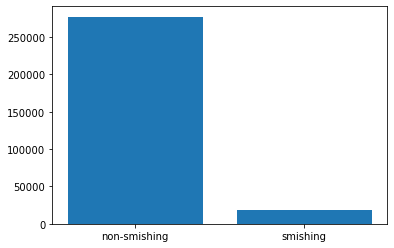

In [5]:
plt.bar(x=["non-smishing","smishing"],height=rawdata["smishing"].value_counts())
plt.show()

In [7]:
## target과 text를 분리해서 담는다.

target = rawdata["smishing"]
text = rawdata["text"]

# EDA

## 1. 타깃간 문장 길이에 차이가 있는가?

In [8]:

length = DataFrame()

for i,j in enumerate(np.array(text)):
    good = DataFrame([len(j)],index=[i])
    length = pd.concat([length,good],axis=0)

In [6]:

length_1 = DataFrame()

for i,j in enumerate(np.array(text)[target[target == 1].index]):
    good = DataFrame([len(j)],index=[i])
    length_1 = pd.concat([length_1,good],axis=0)

In [ ]:
length_0 = DataFrame()

for i,j in enumerate(np.array(text)[target[target == 0].index]):
    good = DataFrame([len(j)],index=[i])
    length_0 = pd.concat([length_0,good],axis=0)

In [ ]:
length_1.describe()

In [170]:
length_0.describe()

,0
count,277242.000000
mean,133.742391
std,149.335552
min,1.000000
25%,39.000000
50%,75.000000
75%,172.000000
max,1498.000000


In [179]:
18703/(277242+18703)

0.0631975535994864

In [172]:
(18703/277242) * 10000

674.6091861983393

In [8]:
length_1 = length_1.reset_index(drop=True)
length_0 = length_0.reset_index(drop=True)

In [9]:
length_1_sample = length_1.loc[np.random.randint(1,len(length_1),675)]
length_0_sample = length_0.loc[np.random.randint(1,len(length_0),10000)]

In [10]:
## KS검정

stats.ks_2samp(np.array(length_1_sample.T)[0],np.array(length_0_sample.T)[0])

Ks_2sampResult(statistic=0.8933481481481481, pvalue=0.0)

### 0와 1 사이에 평균은 차이가 있다. 그리고, 스미싱쪽이 문장이 더 길다.

In [7]:
length.describe()

,0
count,295945.000000
mean,175.911700
std,223.469344
min,1.000000
25%,40.000000
50%,88.000000
75%,201.000000
max,1498.000000


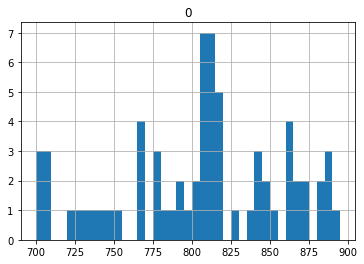

In [124]:
a = length.hist(bins=np.arange(700,900,5))
plt.show(a)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021205748FD0>]],
      dtype=object)

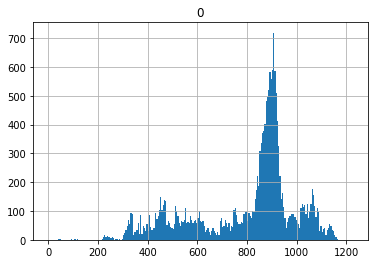

In [157]:
length_1.hist(bins=np.arange(0,1230,5))

In [85]:
rawdata.groupby("year_month")["smishing"].value_counts().unstack().loc[:,1].index

Index(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12'],
      dtype='object', name='year_month')

In [91]:
plt.plot(y = rawdata.groupby("year_month")["smishing"].value_counts().unstack().loc[:,1].values, x = rawdata.groupby("year_month")["smishing"].value_counts().unstack().loc[:,1].index)

[]

## 2. 어떤 형태소분석기가 분석 목적에 더 잘 맞는가?

In [22]:
from konlpy.tag import Okt
from konlpy.tag import Komoran
from konlpy.tag import Kkma

Okt = Okt()
Kom = Komoran()
Kkma = Kkma()


In [23]:
text[target[target == 1].index]

9         (광고)XXXBaXXX고객님들 뒤엔XXX 언제나 XXX새로운 마음가짐으로 새롭게 준...
23        (광고)XXX추가 XXX품   특판 안내문XXX 지점에서 취급하고 있는 여신 XXX...
31        (광고)XXX신용관리 XXX 알고 싶다나의 신용과 재무상태는 직접 관리해야지 누군가...
40        (광고)안녕하세요수신을 희망하지 않으실 경우에는 거부 라는 답장을 주시면 KISA ...
50        (광고)한국citi bank 나의 대출한도와 금리는? 대출때문에 고민하고 있다거나 ...
67        (광고)다사다난했던 병신()년을 보내고 새로운 정유()년에는 늘 좋은 일과 뜻하시는...
71        (광고)한국 (XXX XXX)2분의 시간만 투자하시면 월200만원 SAVE(절감)되...
107       (광고)한국citi bank나의 대출한도와 금리는?대출때문에 고민하고 있다거나 높은...
129       (광고)신용협동조합 안내XXX세요하루하루 힘든업무와 스트레스에 고생많으십니다여유시간...
135       (광고)신협안녕하십니까 하루하루 힘들고 스트레스 받는 대한민국에서 고생이 많으신데 ...
144       (광고)한국citi bank나의 대출한도와 금리는?대출때문에 고민하고 있다거나 높은...
160       (광고)한국XXX XXX이글을 읽는데 2분의 시간만 투자하시면 많은 도움이 되실껍니...
164       (광고)XXXBXXX추운겨울 따뜻한금융 XXXBXXX따뜻한 금융이 누구보다 XXX ...
169       (광고)XXX 신용관리를 통한 현명한 지출관리 정유년 새해 복 많이 받으세요! 1월...
175       (광고)한국citi bank나의 대출한도와 금리는?대출때문에 고민하고 있다거나 높은...
200       (광고)한국citi bank나의 대출한도와 금리는?대출때문에 고민하고 있다거나 높은...
210       안녕하세요?바XXX에 지장드릴까봐 문자로 연락드립니다.

In [142]:
#피싱문자

text[323]

'(광고)정유년 새해 복 많이 받으세요!!한국이지론에서 대출심사 기준이 완화되어 상품안내차 연락드립니다. 매우 바쁘신줄은 알지만 조금만 시간을 내어서 읽어주시면 홍보성 문자이나 필요한 한분 한분에게 도움이 되고자 합니다. 대상 - 직장인사업자프리랜서주부금리 - 최저 4.24%  1 담보대출은 대출한도에 영향을주지않으므로 담보대출이 과다하여도 대출가능2 소비자금융권대출 있으셔도 대환대출로 진행가능3 대출건수조회기록이 많아도  진행가능4 신용등급 상관없이 연체있어도 진행가능XXX 고객님들이 바쁘셔서 혹은 시중은행 가계대출(신용대출)이 제한되면서 현금서비스 및 고금리의 2금융권상품(카드론XXXXXX)을 많이들 사용하고 계십니다XXX 고객님들을 낮은 금리의 전환대출 및 부채통합을 도와드리고 있습니다. (분산된 부채 XXX 고객님들 부채를 0원으로 만들어 드린 상태에서 신용등급 상승 및 한도 발생  매월 내시는 불입금액에 대한 부담감소 이자비용의 절감 이번 기회에 은행권 저금리상품으로 전환도 알아보시길 바랍니다)신청방법상담 가능 시간.성함.으로 문자예약.또는 전화주시면 상담가능하십니다.감사합니다.부채통합 생계자금 동시진행가능한국이지론 수탁법인상담전화XXX-XXX-XXX해당이 되지 않으시거나 거부를 원하시는 분들은 거부라고 회신하여 주신다면 재발송 않도록 하겠습니다. 번호의 오류나 전산의 실수가 있을 수 있사오니 양해 부탁드립니다.한국이지론 담당 박신혜무료수신거부XXX-XXX-XXX정유년 새해 복 많이 받으세요!!'

In [139]:
np.array(Okt.nouns(text[323]))

array(['광고', '정유년', '새해', '복', '한국', '론', '대출', '심사', '기준', '완화', '상품',
       '연락', '매우', '줄', '알', '조금', '시간', '어서', '홍보', '문자', '분', '분', '도움',
       '대상', '직장인', '사업자', '프리랜서', '주부', '금리', '최저', '담보', '대출', '대출',
       '한도', '영향', '주지', '담보', '대출', '과', '대출', '가능', '소비자금융', '대출', '환',
       '대출', '진행', '가능', '대출', '건', '조회', '기록', '진행', '가능', '신용등급', '연체',
       '진행', '가능', '고객', '시중', '은행', '가계', '대출', '신용', '대출', '이', '제한',
       '현금', '서비스', '및', '금리', '금융', '상품', '카드', '론', '사용', '고객', '금리',
       '전환', '대출', '및', '부채', '통합', '도', '분산', '부채', '고객', '부채', '상태',
       '신용등급', '상승', '및', '한도', '발생', '매월', '내시', '불입', '금액', '대한', '부담',
       '감소', '자비', '용의', '절감', '이번', '기회', '은행권', '금리', '상품', '전환', '신청',
       '방법', '상담', '가능', '시간', '성함', '문자', '예약', '전화', '주시', '상담', '부채',
       '통합', '생계', '자금', '진행', '가능', '한국', '론', '수탁', '법인', '상담', '전화',
       '해당', '거부', '분', '거부', '회신', '재', '발송', '번호', '오류', '전산', '실수',
       '수', '양해', '한국', '론', '담당', '박신혜', '무료', '거부', '

In [140]:
np.array(Kkma.nouns(text[323]))

array(['광고', '정유', '새해', '복', '한국', '한국이지', '이지', '대출', '대출심사', '심사',
       '기준', '완화', '상품', '상품안내차', '안내', '차', '연락', '줄', '조금', '시간', '내',
       '홍보', '문자', '필요', '분', '도움', '대상', '직장', '프리랜서', '직장인사업자', '인사',
       '업자', '주부', '주부금리', '금리', '최', '4.24', '1', '담보', '담보대출', '대출한도',
       '한도', '영향', '과다', '대출가능2', '가능', '2', '소비자', '소비자금융권대출', '금융권',
       '대환', '대환대출', '진행', '진행가능3', '3', '대출건수조회기록', '건수', '조회', '기록',
       '진행가능4', '4', '신용', '신용등급', '등급', '연체', '진행가능', '객님', '시중', '시중은행',
       '은행', '가계', '가계대출', '신용대출', '이', '제한', '현금', '현금서비스', '서비스', '고금리',
       '2금융권상품', '카드', '을', '사용', '전환', '전환대출', '부채', '부채통합', '통합', '분산',
       '0', '0원', '원', '상태', '상승', '발생', '내시', '입금액', '부담', '부담감소', '감소',
       '이자', '이자비용', '비용', '절감', '이번', '기회', '은행권', '저금리', '저금리상품', '신청',
       '신청방법상담', '방법', '상담', '성함', '문자예약', '예약', '전화', '전화주시', '주시',
       '상담가능', '감사', '생계', '생계자금', '자금', '동시', '동시진행가능', '국', '국이지', '수탁',
       '수탁법인상담전화', '법인', '해당', '거부', '분', '회신', '재', '

In [141]:
np.array(Kom.nouns(text[323]))

array(['광고', '정유', '년', '새해', '복', '한국', '이지', '대출', '심사', '기준', '완화',
       '상품', '안내', '차', '연락', '줄', '조금', '시간', '홍보', '문자', '필요', '분', '분',
       '도움', '대상', '직장인', '사업자', '프리랜서', '주부', '금리', '최저', '담보', '대출',
       '대출', '한도', '영향', '담보', '대출', '과다', '대출', '가능', '소비자금융', '권', '대출',
       '대환', '대출', '진행', '가능', '대출', '건수', '조회', '기록', '진행', '가능', '신용등급',
       '연체', '진행', '가능', 'XXX', '고객', '시중', '은행', '가계', '대출', '신용', '대출',
       '제한', '현금', '서비스', '고금리', '금융', '권', '상품', '카드론', '사용', '고객', '금리',
       '전환', '대출', '부채', '통합', '분산', '부채', '고객', '부채', '원', '상태', '신용등급',
       '상승', '한도', '발생', '내시', '입금액', '부담', '감소', '이자', '비용', '절감', '이번',
       '기회', '은행', '저금리', '상품', '전환', '신청', '방법', '상담', '시간', '성함', '문자',
       '예약', '전화', '주시', '상담', '감사', '부채', '통합', '생계', '자금', '동시', '진행',
       '가능', '한국', '이지', '수', '탁', '법인', '상담', '전화', 'XXX', '해당', '거부',
       '분', '거부', '회신', '발송', '번호', '오류', '전산', '실수', '수', '양해', '부탁',
       '한국', '이지', '담당', '박신혜', '무료', '수신', '거

### 문구를 의미단의로 잘 분리하는 꼬꼬마를 쓰자 -> Out of Memory 발생. Komoran으로 대체 사용

# 데이터 전처리

In [24]:
def vect_tokenizer(text):
    return Kom.nouns(text)

In [25]:
## CountVectorizer로 문자 : 숫자로 이루어진 색인 사전을 만든다.
## 이미 만들어진 색인사전을 이용해도 됩니다.

zero_or_one = input("있는 색인사전을 쓸까요(0), 아님 신규로 만들까요(1)")

if zero_or_one == "1":
    vect = CountVectorizer(tokenizer = vect_tokenizer ,min_df = 10, analyzer = "word")
    vect.fit(text)
    vocabulary = vect.vocabulary_
    DataFrame([vect.vocabulary_]).to_csv("색인사전.csv",encoding="utf-8",index=False)
if zero_or_one == "0":
    vocabulary = pd.read_csv("색인사전.csv",engine="python",encoding="utf-8")
    vocabulary = vocabulary.to_dict(orient="records")[0]

있는 색인사전을 쓸까요(0), 아님 신규로 만들까요(1)0


In [26]:
zero_or_one = input("있는 벡터화 쓸까요(0), 아님 신규로 만들까요(1)")

morphsVectored = list()

if zero_or_one == "1":

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    morphs = list()

    for i in text:
        morphs.append(Kom.nouns(i))
        
        
    for i in morphs:
        temporailyList = list()
        for k in i:
            #print(k)
            try:
                temporailyList.append(vocabulary[k])
            except KeyError:
                temporailyList.append(0)
        morphsVectored.append(temporailyList)

    DataFrame(morphsVectored).to_csv("벡터화.csv",index=False,encoding="utf-8")

if zero_or_one == "0" :
    morphsVectored = list()
    rawdata = pd.read_csv("벡터화.csv",engine="python",encoding =" utf-8")

    for i in range(0,len(rawdata)):
        morphsVectored.append(list(rawdata.loc[i,:].dropna()))
        



있는 벡터화 쓸까요(0), 아님 신규로 만들까요(1)0


In [96]:
## 윈도우 길이 탐색

length_1_morph = DataFrame()

for i,j in enumerate(np.array(morphsVectored)[target[target == 1].index]):
    good = DataFrame([len(j)],index=[i])
    length_1_morph = pd.concat([length_1_morph,good],axis=0)

In [100]:
length_0_morph = DataFrame()

for i,j in enumerate(np.array(morphsVectored)[target[target == 0].index]):
    good = DataFrame([len(j)],index=[i])
    length_0_morph = pd.concat([length_0_morph,good],axis=0)

In [16]:
length_1_morph.describe()

NameError: name 'length_1_morph' is not defined

In [103]:
length_0_morph.describe()

,0
count,277242.000000
mean,24.719296
std,27.939401
min,0.000000
25%,8.000000
50%,14.000000
75%,30.000000
max,499.000000


# 모델 작성

1. 트랜스포머

In [27]:
TFB = transformer.TransformerBlock(
    name='transformer',
    num_heads=8,
    residual_dropout=0.1,
    attention_dropout=0.1,
    use_masking=True)

In [32]:
positional = position.TransformerCoordinateEmbedding(256)

In [115]:
#tf.reset_default_graph

## GRU 입력 전 사전처리 모듈(임베딩 -> 컨볼루션 -> 맥스풀링)

inputs = layers.Input(shape=[650],name = "Feed_Sentence")

embed = layers.Embedding(len(vocabulary)+1,128)

embed_i = embed(inputs)
cnns = layers.Dropout(0.2)(embed_i)
cnns = layers.Conv1D(256,3,padding="valid",activation="relu",strides=1)(cnns)
cnns = layers.MaxPooling1D(pool_size = 4)(cnns)

for step in range(3):
    tfb = TFB(positional(cnns,step=step))
    
context_vector = layers.Flatten()(tfb)

predicts = layers.Dense(2,activation="softmax")(context_vector)

tfbs = Model(inputs = [inputs], outputs = [predicts])
tfbs.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feed_Sentence (InputLayer)      (None, 650)          0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 650, 128)     1102720     Feed_Sentence[0][0]              
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 650, 128)     0           embedding_20[0][0]               
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 648, 256)     98560       dropout_20[0][0]                 
__________________________________________________________________________________________________
max_poolin

# 2. 계층적 GRU

In [23]:
#tf.reset_default_graph

## GRU 입력 전 사전처리 모듈(임베딩 -> 컨볼루션 -> 맥스풀링)

inputs = layers.Input(shape=[None],name = "Feed_Sentence")

embed = layers.Embedding(len(vocabulary)+1,128)

embed_i = embed(inputs)
cnns = layers.Dropout(0.2)(embed_i)
cnns = layers.Conv1D(256,3,padding="valid",activation="relu",strides=1)(cnns)
cnns = layers.MaxPooling1D(pool_size = 4)(cnns)


#Bi-GRU 인코더 - 디코더 네트워크
Encoder1 = layers.GRU(128,return_sequences = True,return_state = True,input_shape=(None,128),name="Encoder1")
Encoder2 = layers.GRU(128,return_sequences = True,return_state = True,go_backwards = True,input_shape=(None,128),name="Encoder2")
attention_matrix1,initial_1 = Encoder1(cnns)
attention_matrix2,initial_2 = Encoder2(cnns)
attention_matrix = layers.Concatenate(axis=-1,name = "attention_matrix")([attention_matrix1,attention_matrix2])


Decoder1 = layers.GRU(128,return_sequences = True,input_shape=(None,128),name="Decoder1")
Decoder2 = layers.GRU(128,return_sequences = True,input_shape=(None,128),name="Decoder2")
Decoder1_output = Decoder1(cnns,initial_state = initial_1)
Decoder2_output = Decoder2(cnns,initial_state = initial_2)
Decoder_output = layers.Concatenate(axis=-1,name="Decoder_output")([Decoder1_output,Decoder2_output])


##어텐션 메커니즘 부분

#normalize = True로 켠 상태에서, 코싸인 유사도를 구할 수 있도록 둘을 내적한다.  
dot_product_similarity = layers.dot([Decoder_output,attention_matrix],axes = -1,normalize=True,name="dot_product_similarity")

#유사도 벡터를 softmax층에 통과시켜 총합이 1인 확률로 변환한다. 이를 attention_score로 명명한다.
attention_score_layer = layers.Softmax(axis=-1,name="attention_score_from_Softmax") 
attention_score = attention_score_layer(dot_product_similarity)

#Softmax 변환된 attention_score를 최초의 attention_matrix와 각각 내적한다.
weighted_attention_matrix = layers.Lambda(lambda x: K.tf.matmul(K.permute_dimensions(x[1],pattern=(0,2,1)),x[0]),name="weighted_attention_matrix")([attention_score,attention_matrix])
weighted_attention_matrix = layers.Permute((2,1))(weighted_attention_matrix)

_,context_vector = layers.GRU(64,return_state = True,name="Hierarchical_GRU")(weighted_attention_matrix)

#concat = layers.Concatenate(axis=-1,name = "Concatenate_Decoder_O_and_Context_Vector")([Decoder_output,weighted_attention_matrix])
#context_vector = layers.Lambda(lambda x: K.sum(x, axis=1),name="Making_context_vector")(weighted_attention_matrix)

#Feed_forward = layers.Dense(512,activation = "tanh",name="Feed_forward")
#finally_output = Feed_forward(context_vector)

predicts = layers.Dense(2,activation="softmax")(context_vector)

GRUs_2 = Model(inputs = [inputs], outputs = [predicts])
GRUs_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feed_Sentence (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 128)    1102720     Feed_Sentence[0][0]              
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, None, 128)    0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, None, 256)    98560       dropout_4[0][0]                  
__________________________________________________________________________________________________
max_poolin

## 1) 계층적 GRU의 얼개도

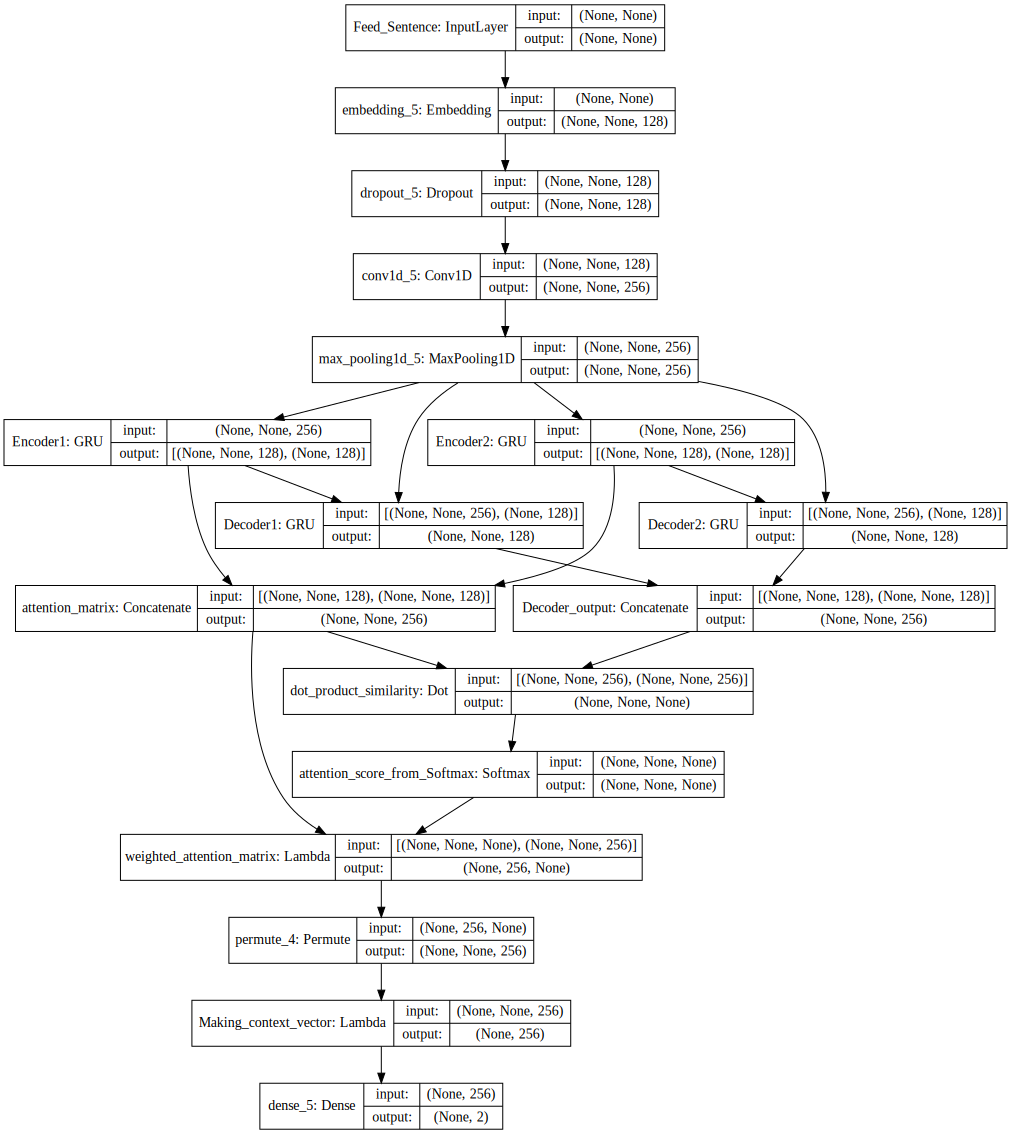

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

SVG(model_to_dot(GRUs_2,show_shapes=True).create(prog="dot",format="svg"))
#plot_model(GRUs_2, to_file='model.png',show_shapes = True)

# 3. CNN-LSTM

In [120]:
cnn_lstm = Sequential()
cnn_lstm.add(Embedding(len(vocabulary)+1,128,input_length = None))
cnn_lstm.add(Dropout(0.2))
cnn_lstm.add(Conv1D(256,3,padding="valid",activation="relu",strides=1))
cnn_lstm.add(MaxPooling1D(pool_size = 4))
cnn_lstm.add(LSTM(128))
cnn_lstm.add(Dense(2,activation="softmax"))

cnn_lstm.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [121]:
cnn_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 128)         1102720   
_________________________________________________________________
dropout_21 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 256)         98560     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, None, 256)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
Total params: 1,398,658
Trainable params: 1,398,658
Non-trainable params: 0
_________________________________________________________________


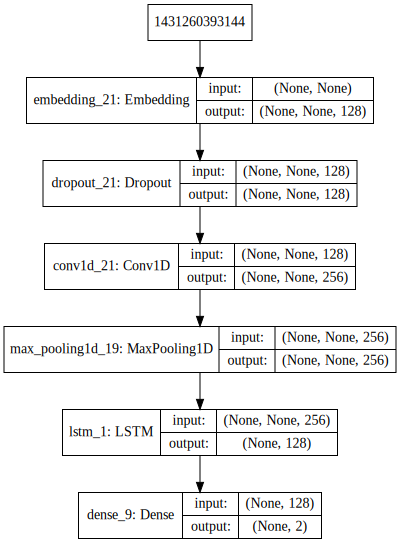

In [122]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

SVG(model_to_dot(cnn_lstm,show_shapes=True).create(prog="dot",format="svg"))
#plot_model(GRUs_2, to_file='model.png',show_shapes = True)

# train,test 분할

In [44]:
vectorized_seq = sequence.pad_sequences(morphsVectored,maxlen = 650)

# 함수 모음 : AUC 콜백함수

1. 평가용 AUC 콜백 함수

In [155]:
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

2. 배치 생성 연속 샘플링

In [45]:
def sampling_feed(vectorized_seq,target,temp_index,sam_num):
    
    temp = pd.concat([DataFrame(vectorized_seq),target],axis=1)
    temp = temp.loc[temp.index.difference(temp_index),:]
    temp_sampling = temp.sample(sam_num)
    
    print("original_ratio :",len(temp[temp["smishing"] == 1])/len(temp[temp["smishing"] == 0]))
    print("sampling_ratio :",len(temp_sampling[temp_sampling["smishing"] == 1])/len(temp_sampling[temp_sampling["smishing"] == 0]))
    
    target_sample = temp_sampling["smishing"].values.copy()
    del(temp_sampling["smishing"])
    vectorized_seq_sample = np.array(temp_sampling).copy()
    
    temp_index = np.hstack([temp_index,temp_sampling.index])
    
    return(temp_index,vectorized_seq_sample,target_sample)

# 실제 적합

1. Transformer 

In [48]:
X_train,X_test,y_train,y_test = train_test_split(vectorized_seq, target,test_size=0.2)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [51]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 3)

In [117]:
tfbs.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [118]:
tfbs.fit(X_train,y_train,epochs=1,batch_size = 64,validation_data = (X_test,y_test),callbacks = [early_stopping])

Train on 236756 samples, validate on 59189 samples
Epoch 1/1
236756/236756 [==============================] - 4201s 18ms/step - loss: 1.0181 - acc: 0.9366 - val_loss: 1.0217 - val_acc: 0.9366


2. 계층적 GRU 모델

In [ ]:
GRUs_2.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [266]:
temp_index = np.array([])

for i in range(0,6):
    
    temp_index, vectorized_seq_sample,target_sample = sampling_feed(vectorized_seq,target,temp_index,20000)
    X_train,X_test,y_train,y_test = train_test_split(vectorized_seq_sample, target_sample,test_size=0.2)
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    GRUs_2.fit(X_train,y_train,epochs=20,batch_size = 64,validation_data = (X_test,y_test),callbacks = [early_stopping])

original_ratio : 0.06746091861983393
sampling_ratio : 0.06490602204355465
Train on 16000 samples, validate on 4000 samples
Epoch 1/20
16000/16000 [==============================] - 993s 62ms/step - loss: 3.6054e-05 - acc: 1.0000 - val_loss: 5.0531e-04 - val_acc: 0.9998
Epoch 2/20
16000/16000 [==============================] - 984s 62ms/step - loss: 8.7946e-06 - acc: 1.0000 - val_loss: 7.9293e-06 - val_acc: 1.0000
Epoch 3/20
16000/16000 [==============================] - 984s 62ms/step - loss: 5.7928e-06 - acc: 1.0000 - val_loss: 6.5517e-06 - val_acc: 1.0000
Epoch 4/20
16000/16000 [==============================] - 985s 62ms/step - loss: 4.5928e-06 - acc: 1.0000 - val_loss: 5.1713e-06 - val_acc: 1.0000
Epoch 5/20
16000/16000 [==============================] - 985s 62ms/step - loss: 3.7695e-06 - acc: 1.0000 - val_loss: 4.4287e-06 - val_acc: 1.0000
Epoch 6/20
16000/16000 [==============================] - 987s 62ms/step - loss: 3.1431e-06 - acc: 1.0000 - val_loss: 3.9392e-06 - val_acc: 1.

In [240]:
y_pred = GRUs_2.predict(X_train)
roc = roc_auc_score(y_train, y_pred)
y_pred_val = GRUs_2.predict(X_test)
roc_val = roc_auc_score(y_test, y_pred_val)
print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')

roc-auc: 1.0 - roc-auc_val: 1.0                                                                                                    


3. cnn-LSTM 모델

In [262]:
temp_index = np.array([])

for i in range(0,6):
    
    temp_index, vectorized_seq_sample,target_sample = sampling_feed(vectorized_seq,target,temp_index,20000)
    X_train,X_test,y_train,y_test = train_test_split(vectorized_seq_sample, target_sample,test_size=0.2)
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

    cnn_lstm.fit(X_train,y_train,epochs=20,batch_size=64,validation_data=(X_test,y_test),callbacks=[early_stopping])

original_ratio : 0.06822347819445505
sampling_ratio : 0.06877571741570032
Train on 16000 samples, validate on 4000 samples
Epoch 1/20
16000/16000 [==============================] - 262s 16ms/step - loss: 5.2588e-04 - acc: 0.9999 - val_loss: 0.0031 - val_acc: 0.9995
Epoch 2/20
16000/16000 [==============================] - 263s 16ms/step - loss: 5.2551e-06 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 0.9995
Epoch 3/20
16000/16000 [==============================] - 265s 17ms/step - loss: 2.4105e-06 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 0.9995
Epoch 4/20
16000/16000 [==============================] - 265s 17ms/step - loss: 1.6479e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 0.9992
original_ratio : 0.06791645622270417
sampling_ratio : 0.0672358591248666
Train on 16000 samples, validate on 4000 samples
Epoch 1/20
16000/16000 [==============================] - 263s 16ms/step - loss: 0.0035 - acc: 0.9992 - val_loss: 1.1269e-04 - val_acc: 1.0000
Epoch 2/20
16000/16000 [================

ValueError: Cannot take a larger sample than population when 'replace=False'

In [115]:
model.fit(X_train,y_train,epochs=10,batch_size=64,validation_data=(X_test,y_test),callbacks=[early_stopping])

Train on 221958 samples, validate on 73987 samples
Epoch 1/10
221958/221958 [==============================] - 1409s 6ms/step - loss: 5.0465e-04 - acc: 0.9999 - val_loss: 0.0010 - val_acc: 0.9999
Epoch 2/10
221958/221958 [==============================] - 1406s 6ms/step - loss: 2.5936e-04 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 0.9999
Epoch 3/10
221958/221958 [==============================] - 1420s 6ms/step - loss: 2.6522e-04 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 0.9995
Epoch 4/10
221958/221958 [==============================] - 1418s 6ms/step - loss: 2.6839e-04 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 0.9999


In [121]:
y_pred = model.predict(X_train)
roc = roc_auc_score(y_train, y_pred)
y_pred_val = model.predict(X_test)
roc_val = roc_auc_score(y_test, y_pred_val)
print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')

roc-auc: 1.0 - roc-auc_val: 0.9998                                                                                                    


# Submission

In [68]:
validation = pd.read_csv("public_test.csv")

In [69]:
text_val = validation["text"]

In [70]:
length = DataFrame()

for i,j in enumerate(text_val):
    good = DataFrame([len(j)],index=[i])
    length = pd.concat([length,good],axis=0)

In [71]:
length.describe()

,0
count,1626.000000
mean,320.535670
std,251.631687
min,4.000000
25%,130.250000
50%,230.500000
75%,443.750000
max,1155.000000


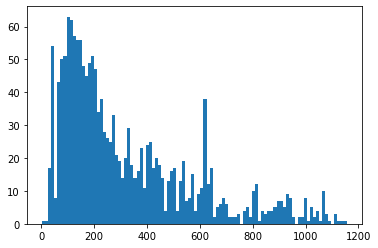

In [72]:
plt.hist(length[0],bins=100)
plt.show()

In [73]:
## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
## 시간이 오래 걸립니다. 5분정도

morphs_val = list()

for i in text_val:
    morphs_val.append(Kom.nouns(i))

In [77]:
#색인사전을 검색해 토큰화한 파일을 숫자로 바꾸어준다.

morphsVectored_val = list()

for i in morphs_val:
    temporailyList = list()
    for k in i:
        #print(k)
        try:
            temporailyList.append(vocabulary[k])
        except KeyError:
            temporailyList.append(0)
    morphsVectored_val.append(temporailyList)

In [78]:
vectorized_seq_val = sequence.pad_sequences(morphsVectored_val,maxlen = 650)

In [80]:
val_predict = tfbs.predict(vectorized_seq_val)

In [84]:
submission = pd.concat([validation["id"],DataFrame(val_predict[0],columns=[0,"smishing"])["smishing"]],axis=1)

In [85]:
submission.to_csv("submission.csv",encoding="utf-8",index=False)